In [ ]:
# Update xgboost 
!pip install -U xgboost

In [27]:
from IPython.display import display, Markdown

import pandas as pd
import gc
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline

from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold, cross_val_score

from sklearn.metrics import roc_auc_score

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval

from sklearn.tree import plot_tree

from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler

# XGBoost
import xgboost as xgb

In [2]:
"""
Columns
The following columns are available on the training set:

accepts_mercadopago Whether the item accepts Mercado Pago
available_quantity The available stock quantity at that moment
avg_asp_item_bday Average selling price of this item over the last days
avg_asp_item_domain Average price of items of the domain this item belongs to
avg_asp_item_sel Average price of seller sales
avg_gmv_item_bday average revenue generated by the item per day
avg_gmv_item_domain_30days Average revenue generated by the items of this domain on the last month
avg_gmv_item_sel Average revenue of items of this seller
avg_gmv_seller_bday Average revenue this seller makes by day
avg_orders_item_bday Average number of orders this item has by day
avg_orders_seller_bday Average orders the seller has by day
avg_qty_orders_item_domain_30days Average number of orders a random item of this domain made on the last month
avg_qty_orders_item_sel_30days Average number of orders an item of this seller makes on the last 30 days
avg_si_item_bday Average units sold this item has by day
avg_si_item_sel_30day Average units sold of an item of this seller on the past month
avg_visits_item Average visits this item had
benefit Ignore, should be dropped
boosted Whether the item was boosted
buy_server_timestamp Timestamp of the purchase
category_id Category of this item
conversion Target variable, it is True if this print has an attributed order
cus_cust_id Buyer id
cus_cust_id_sel Seller id
date Print date
deal_print_id Unique id for the print
decimals Ignore, will be dropped
domain_id Domain id for the item
etl_version Ignore, should be dropped
free_shipping Whether the item has free shipping
fulfillment Whether the item is fulfilled by MeLi
full_name Category full name
health Item health
is_pdp Whether the click landed on a PDP
product_id Product_id of the item
item_id ID of the item, useful for debugging
listing_type_id Whether the item is gold or not
logistic_type Logistic type for the item
main_picture URL for the main item picture
offset On which page the item was rendered
original_price Price from which the discount was done
platform Which platform the user is using
price Item price
print_position Position on the page
print_server_timestamp Timestamp for the print
qty_items_dom Number of items this domain has
qty_items_sel Number of items the seller has
rn Leftover from the ETL, Discard
ROW_ID Row of the submission file
site_id Site ID
sold_quantity Number of items sold at the moment of the print
tags Tags the item had at the moment of the print
title Item title
total_asp_item_domain_30days Average selling price of the items of the domain
total_asp_item_sel_30days Average selling price of all the items the seller sold on the last 30 days
total_gmv_domain_30days Total revenue the domain made on the last 30 days
total_gmv_domain_bday total_gmv_domain_30days / 30
total_gmv_item_30days Total revenue made by the item on the lasts 30 days
total_gmv_seller Total revenue made by the seller on the last month
total_items_domain Number of items on the domain
total_items_seller Number of items the seller has
total_orders_domain_30days Total orders on the domain
total_orders_item_30days Total orders the Item had on the last 30 days
total_orders_sel_30days Total orders for the seller
total_si_domain_30days Total units sold of this domain
total_si_item_30days Total units sold of this item
total_si_sel_30days Same for the seller
total_visits_domain Total visits on this domain
total_visits_item Total visits this item had
total_visits_seller Total visits for this seller
uid session id
user_id user id
warranty Whether the item had warranty
"""

'\nColumns\nThe following columns are available on the training set:\n\naccepts_mercadopago Whether the item accepts Mercado Pago\navailable_quantity The available stock quantity at that moment\navg_asp_item_bday Average selling price of this item over the last days\navg_asp_item_domain Average price of items of the domain this item belongs to\navg_asp_item_sel Average price of seller sales\navg_gmv_item_bday average revenue generated by the item per day\navg_gmv_item_domain_30days Average revenue generated by the items of this domain on the last month\navg_gmv_item_sel Average revenue of items of this seller\navg_gmv_seller_bday Average revenue this seller makes by day\navg_orders_item_bday Average number of orders this item has by day\navg_orders_seller_bday Average orders the seller has by day\navg_qty_orders_item_domain_30days Average number of orders a random item of this domain made on the last month\navg_qty_orders_item_sel_30days Average number of orders an item of this seller 

In [28]:
def load_comp():
    # Load the competition data
    comp_data = pd.read_csv("data/competition_data.csv")
    comp_data = comp_data.drop(
        columns=[
            "benefit", 
            "etl_version", 
            "uid",
            "date",
            "deal_print_id",
            "full_name",
            "main_picture",
            "warranty",
            "tags",
            "print_server_timestamp",
            "print_position",
            "title",
            "accepts_mercadopago"
        ]
    )
    # OHE comp_data columns
    comp_data = pd.get_dummies(comp_data, 
        sparse=True,
        columns=[
            #"category_id", 
            #"domain_id", 
            "logistic_type", 
            "platform", 
            "site_id"
        ],
        dtype=int
    )
    #comp_data["accepts_mercadopago"] = comp_data["accepts_mercadopago"].astype(int)
    # todos aceptan mercadopago
    comp_data["boosted"] = comp_data["boosted"].astype(int)
    comp_data["free_shipping"] = comp_data["free_shipping"].astype(int)
    comp_data["fulfillment"] = comp_data["fulfillment"].astype(int)

    comp_data["is_pdp"].fillna(0, inplace=True)
    comp_data["is_pdp"] = comp_data["is_pdp"].astype(int)
    #comp_data["warranty"] = comp_data["warranty"].astype(int)

    # comp_data["listing_type_id"] to 0 if gold_special, 1 if gold_pro.
    comp_data["listing_type_id"] = comp_data["listing_type_id"].apply(lambda x: 0 if x == "gold_special" else 1)
    
    # Label encode category_id and domain_id
    # comp_data["category_id"] = comp_data["category_id"].astype("category")#.cat.codes
    #comp_data["domain_id"] = comp_data["domain_id"].astype("category")#.cat.codes

    # sklearn LabelEncoder for category_id and domain_id
    
    comp_data["category_id"] = LabelEncoder().fit_transform(comp_data["category_id"]).astype(int)
    comp_data["domain_id"] = LabelEncoder().fit_transform(comp_data["domain_id"]).astype(int)
    comp_data["item_id"] = LabelEncoder().fit_transform(comp_data["item_id"]).astype(int)

    comp_data["price_diff"] = comp_data["price"] - comp_data["original_price"]
    comp_data["cheaper_than_original"] = comp_data["price_diff"].apply(lambda x: 1 if x < 0 else 0)
    comp_data["price_diff"] = comp_data["price_diff"].apply(lambda x: abs(x)).astype(int)

    #comp_data["cheaper_than_avg"] = comp_data["price"] - comp_data["avg_asp_item_domain"]
    #comp_data["cheaper_than_avg"] = comp_data["cheaper_than_avg"].apply(lambda x: 1 if x < 0 else 0).astype(int)

    # Drop useless columns
    # comp_data = comp_data.drop(
    #     columns=[
    #     ]
    # )

    return comp_data

In [22]:
comp_data = load_comp()
comp_data["item_id"].value_counts()

MLA784334044    717
MLA764888251    701
MLA847531773    622
MLA785891221    535
MLA766402693    517
               ... 
MLA833936427      1
MLA663926326      1
MLA784136287      1
MLA812482695      1
MLA762298064      1
Name: item_id, Length: 27695, dtype: int64

In [30]:
# Split into training and evaluation samples
comp_data = load_comp()

display(
    Markdown(
        "\n".join(
            [
                #"- **{}** ({}) \n\n {}".format(col, dtype, comp_data[col].value_counts()) for col, dtype in
                "- **{}** ({})".format(col, dtype) for col, dtype in
                zip(comp_data.columns, comp_data.dtypes)
            ]
        )
    )
)

full_data = comp_data[comp_data["ROW_ID"].isna()]
eval_data = comp_data[comp_data["ROW_ID"].notna()]

# Get number column names for full_data
#print(full_data.columns)
#num_cols = full_data.select_dtypes(include='number').columns
#print(num_cols)
# difference between full_data_cols and num_cols
# print(set(full_data.columns) - set(num_cols))

del comp_data
gc.collect()

train_data, test_data = train_test_split(full_data, test_size=0.20, train_size=0.80, random_state=42)

y_train = train_data["conversion"]
X_train = train_data.drop(columns=["conversion", "ROW_ID"])
X_train = X_train.select_dtypes(include='number')

y_test = test_data["conversion"]
X_test = test_data.drop(columns=["conversion", "ROW_ID"])
X_test = X_test.select_dtypes(include='number')

del train_data
del test_data

gc.collect()

- **available_quantity** (int64)
- **avg_gmv_item_domain_30days** (float64)
- **avg_gmv_item_sel** (float64)
- **avg_gmv_seller_bday** (float64)
- **avg_qty_orders_item_domain_30days** (float64)
- **avg_qty_orders_item_sel_30days** (float64)
- **avg_si_item_sel_30day** (float64)
- **boosted** (int64)
- **category_id** (int64)
- **conversion** (float64)
- **domain_id** (int64)
- **free_shipping** (int64)
- **fulfillment** (int64)
- **health** (float64)
- **is_pdp** (int64)
- **product_id** (float64)
- **item_id** (int64)
- **listing_type_id** (int64)
- **offset** (int64)
- **original_price** (int64)
- **price** (int64)
- **qty_items_dom** (float64)
- **qty_items_sel** (float64)
- **sold_quantity** (int64)
- **total_asp_item_domain_30days** (float64)
- **total_asp_item_sel_30days** (float64)
- **total_gmv_domain_bday** (float64)
- **total_gmv_item_30days** (float64)
- **total_items_domain** (int64)
- **total_items_seller** (int64)
- **total_orders_domain_30days** (float64)
- **total_orders_item_30days** (float64)
- **total_orders_sel_30days** (float64)
- **total_si_domain_30days** (float64)
- **total_si_item_30days** (float64)
- **total_si_sel_30days** (float64)
- **total_visits_domain** (int64)
- **total_visits_item** (int64)
- **total_visits_seller** (int64)
- **user_id** (float64)
- **ROW_ID** (float64)
- **logistic_type_cross_docking** (Sparse[int64, 0])
- **logistic_type_custom** (Sparse[int64, 0])
- **logistic_type_default** (Sparse[int64, 0])
- **logistic_type_drop_off** (Sparse[int64, 0])
- **logistic_type_fulfillment** (Sparse[int64, 0])
- **logistic_type_not_specified** (Sparse[int64, 0])
- **logistic_type_xd_drop_off** (Sparse[int64, 0])
- **platform_/mobile/android** (Sparse[int64, 0])
- **platform_/mobile/ios** (Sparse[int64, 0])
- **platform_/web/desktop** (Sparse[int64, 0])
- **platform_/web/mobile** (Sparse[int64, 0])
- **site_id_MLA** (Sparse[int64, 0])
- **price_diff** (int64)
- **cheaper_than_original** (int64)

55


/Users/nacho/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


ValueError: Input X contains NaN.
PolynomialFeatures does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [36]:
import numpy as np

In [ ]:
atributes_to_poly = [
                        "available_quantity", 
                        "avg_gmv_item_domain_30days", 
                        "avg_gmv_item_sel", 
                        "avg_gmv_seller_bday", 
                        "avg_qty_orders_item_domain_30days", 
                        "avg_qty_orders_item_sel_30days", 
                        "avg_si_item_sel_30day",
                        "original_price",
                        "price",
                    ]

imputed_poly_features = make_pipeline(
  #SimpleImputer(),
  #PolynomialFeatures(),
  StandardScaler(),
  xgb.XGBClassifier(
        missing=np.nan,
        n_jobs=-1,
        tree_method='gpu_hist',
    )
)

# Custom Layer Starts Here:
pl = PolynomialFeatures(2, interaction_only=True, include_bias=False)

#Input X contains NaN.

imputed_X_train_plus = X_train.copy()
imputed_X_test_plus = X_test.copy()
print(imputed_X_train_plus.shape[0] == X_train.shape[0])

# Make new columns indicating what will be imputed
cols_with_missing = (col for col in X_train.columns
                        if X_train[col].isnull().any())

for col in cols_with_missing:
    imputed_X_train_plus[col + '_was_missing'] = imputed_X_train_plus[col].isnull()
    imputed_X_test_plus[col + '_was_missing'] = imputed_X_test_plus[col].isnull()

# Imputation
my_imputer = SimpleImputer()

poly_X_train = imputed_X_train_plus[atributes_to_poly]
poly_X_test = imputed_X_test_plus[atributes_to_poly]
print(poly_X_train.shape[0] == X_train.shape[0])

poly_X_train = my_imputer.fit_transform(poly_X_train)
poly_X_test = my_imputer.transform(poly_X_test)
print(poly_X_train.shape[0] == X_train.shape[0])

poly_X_train = pl.fit_transform(poly_X_train)
poly_X_test = pl.fit_transform(poly_X_test)
print(poly_X_train.shape[0] == X_train.shape[0])

new_X_train = np.concatenate((X_train.drop(atributes_to_poly, axis=1), poly_X_train), axis=1)
new_X_test = np.concatenate((X_test.drop(atributes_to_poly, axis=1), poly_X_test), axis=1)
print(new_X_train.shape[0] == X_train.shape[0])
# Custom Layer Ends Here


imputed_poly_features.fit(new_X_train, y_train)

roc_auc_score(y_test, imputed_poly_features.predict_proba(new_X_test)[:, imputed_poly_features.classes_ == 1])

In [78]:
# Decision Tree Classifier with K-Fold Cross Validation and Randomized Search CV

dtc = make_pipeline(
    SimpleImputer(),
    RandomizedSearchCV(
        DecisionTreeClassifier(random_state=2345),
        param_distributions={
            "max_depth": [2, 4, 8, 16, 32, 64, 128, 256, 512, None],
            "min_samples_split": [2, 4, 8, 16, 32, 64, 128, 256, 512],
            "min_samples_leaf": [2, 4, 8, 16, 32, 64, 128, 256, 512],
            "max_features": [2, 4, 8, 16, 32, 64, 128, 256, 512, None],
        },
        n_iter=100,
        cv=3,
        random_state=2345,
        n_jobs=-1,
        verbose=0,
    )
)

kf = KFold(n_splits=5, random_state=2345, shuffle=True)
roc_aucs = []

for train_index, valid_index in kf.split(X_train):
    X_train_kf, X_valid_kf = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_kf, y_valid_kf = y_train.iloc[train_index], y_train.iloc[valid_index]

    dtc.fit(X_train_kf, y_train_kf)
    # Metric: roc_auc_score
    roc_aucs.append(roc_auc_score(y_valid_kf, dtc.predict_proba(X_valid_kf)[:, dtc.classes_ == 1]))
    print(f"ROC-AUC split {len(roc_aucs)}: ", roc_aucs[-1])

print("ROC-AUC mean: ", sum(roc_aucs) / len(roc_aucs))    

dtc.fit(X_train, y_train)

print("ROC-AUC: ", roc_auc_score(y_test, dtc.predict_proba(X_test)[:, dtc.classes_ == 1]))

ROC-AUC split 1:  0.7062813104270844


KeyboardInterrupt: 

In [21]:
pd.Series(roc_aucs).describe()

count    5.000000
mean     0.719648
std      0.005229
min      0.714328
25%      0.715559
50%      0.717973
75%      0.724961
max      0.725421
dtype: float64

In [ ]:
rfs = make_pipeline(
    SimpleImputer(),
    RandomizedSearchCV(
        RandomForestClassifier(random_state=2345),
        param_distributions={
            "max_depth": [2, 4, 8, 16, 32, 64, 128, None],
            "min_samples_split": [2, 4, 8, 16, 32, 64, 128],
            "min_samples_leaf": [2, 4, 8, 16, 32, 64, 128],
            "max_features": [2, 4, 8, 16, 32, 64, 128, None],
        },
        n_iter=100,
        cv=3,
        random_state=2345,
        n_jobs=-1,
        verbose=2,
    )
)

rfs.fit(X_train, y_train)

In [34]:
space = {
    "max_depth": hp.choice("max_depth", [2, 4, 8, 16, 32, 64, 128, 256, 512, None]),
    "min_samples_split": hp.choice("min_samples_split", [2, 4, 8, 16, 32, 64, 128, 256, 512]),
    "min_samples_leaf": hp.choice("min_samples_leaf", [2, 4, 8, 16, 32, 64, 128, 256, 512]),
    "max_features": hp.choice("max_features", [2, 4, 8, 16, 32, 64, 128, 256, 512, None]),
}

def objective_dct(params):

    kf = KFold(n_splits=10, shuffle=True)

    model = make_pipeline(
        SimpleImputer(),
        DecisionTreeClassifier(**params),
    )

    score = cross_val_score(model, X_train, y_train, scoring="roc_auc", cv=kf, n_jobs=-1).mean()
    # model.fit(X_train, y_train)

    # y_pred = model.predict_proba(X_test)[:, model.classes_ == 1]
    # score = roc_auc_score(y_test, y_pred)

    return {"loss": 1 - score, "status": STATUS_OK}


trials_dct = Trials()

best_dct = fmin(
    fn=objective_dct,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials_dct,
)

print(best_dct)

100%|██████████| 100/100 [09:50<00:00,  5.90s/trial, best loss: 0.26513219216768746]
{'max_depth': 2, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 8}


In [35]:
#best_dct = {'max_depth': 2, 'max_features': 6, 'min_samples_leaf': 6, 'min_samples_split': 6}

hyper_dct = make_pipeline(
    SimpleImputer(),
    DecisionTreeClassifier(**best_dct)
)

hyper_dct.fit(X_train, y_train)

# kf = KFold(n_splits=10, random_state=2345, shuffle=True)
# roc_auc_scores_hdct = []

# for train_index, valid_index in kf.split(X_train):

#     X_train_kf, X_valid_kf = X_train.iloc[train_index], X_train.iloc[valid_index]
#     y_train_kf, y_valid_kf = y_train.iloc[train_index], y_train.iloc[valid_index]

#     hyper_dct.fit(X_train_kf, y_train_kf)
#     # Metric: roc_auc_score
#     roc_auc_scores_hdct.append(roc_auc_score(y_valid_kf, hyper_dct.predict_proba(X_valid_kf)[:, hyper_dct.classes_ == 1]))
#     print(f"ROC-AUC split {len(roc_auc_scores_hdct)}: ", roc_auc_scores_hdct[-1])

print("ROC-AUC: ", roc_auc_score(y_test, hyper_dct.predict_proba(X_test)[:, hyper_dct.classes_ == 1]))

ROC-AUC:  0.6579065690644064


In [39]:
hyper_dct.named_steps["decisiontreeclassifier"]

DecisionTreeClassifier(max_depth=2, max_features=5, min_samples_leaf=6,
                       min_samples_split=8)

[Text(0.5, 0.8333333333333334, 'total_visits_item <= 3133.5\ngini = 0.167\nsamples = 162684\nvalue = [147685, 14999]'),
 Text(0.25, 0.5, 'total_gmv_item_30days <= 270.81\ngini = 0.115\nsamples = 106254\nvalue = [99757, 6497]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.089\nsamples = 52476\nvalue = [50015, 2461]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.139\nsamples = 53778\nvalue = [49742, 4036]'),
 Text(0.75, 0.5, 'total_gmv_item_30days <= 3918.475\ngini = 0.256\nsamples = 56430\nvalue = [47928, 8502]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.214\nsamples = 33062\nvalue = [29031, 4031]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.309\nsamples = 23368\nvalue = [18897, 4471]')]

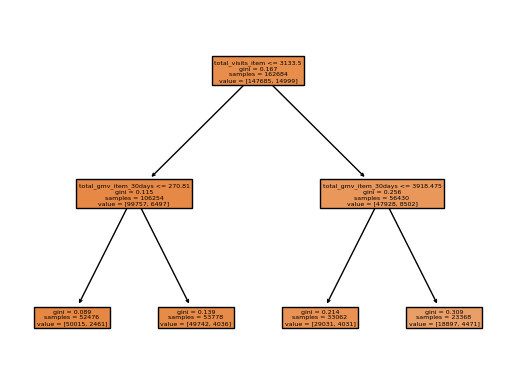

In [40]:
plot_tree(hyper_dct.named_steps["decisiontreeclassifier"], max_depth=2, filled=True, feature_names=list(X_train.columns))

In [48]:
space = {
    "max_depth": hp.choice("max_depth", [2, 4, 8, 16, 32, 64, 128, None]),
    "min_samples_split": hp.choice("min_samples_split", [2, 4, 8, 16, 32, 64, 128]),
    "min_samples_leaf": hp.choice("min_samples_leaf", [2, 4, 8, 16, 32, 64, 128]),
    "max_features": hp.choice("max_features", [2, 4, 8, 16, 32, 64, 128, None]),
}

def objective_rfs(params):
    model = make_pipeline(
        SimpleImputer(),
        RandomForestClassifier(**params, n_estimators=100, n_jobs=-1),
    )

    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_test)[:, model.classes_ == 1]
    score = roc_auc_score(y_test, y_pred)

    return {"loss": 1 - score, "status": STATUS_OK}

trials_rfs = Trials()

best_rfs = fmin(
    fn=objective_rfs,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials_rfs,
)

print(best_rfs)

100%|██████████| 100/100 [38:51<00:00, 23.32s/trial, best loss: 0.2121955631253214] 
{'max_depth': 3, 'max_features': 0, 'min_samples_leaf': 2, 'min_samples_split': 0}


In [58]:
best_rfs["max_features"] = 1
best_rfs["min_samples_split"] = 2

best_rfs

{'max_depth': 3,
 'max_features': 1,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [63]:
hyper_rfs_kf = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(**best_rfs, n_estimators=100, n_jobs=-1)
)

kf = KFold(n_splits=10, random_state=2345, shuffle=True)

roc_auc_scores_hrfs = []

for train_index, valid_index in kf.split(X_train):
    X_train_kf, X_valid_kf = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_kf, y_valid_kf = y_train.iloc[train_index], y_train.iloc[valid_index]

    hyper_rfs_kf.fit(X_train_kf, y_train_kf)
    # Metric: roc_auc_score
    roc_auc_scores_hrfs.append(roc_auc_score(y_valid_kf, hyper_rfs_kf.predict_proba(X_valid_kf)[:, hyper_rfs_kf.classes_ == 1]))
    print(f"ROC-AUC split {len(roc_auc_scores_hrfs)}: ", roc_auc_scores_hrfs[-1])

print("ROC-AUC: ", roc_auc_score(y_test, hyper_rfs_kf.predict_proba(X_test)[:, hyper_rfs_kf.classes_ == 1]))

ROC-AUC split 1:  0.7081469103022364
ROC-AUC split 2:  0.7180935208870816
ROC-AUC split 3:  0.7089286667318965
ROC-AUC split 4:  0.7101126956253258
ROC-AUC split 5:  0.7035800560823728
ROC-AUC split 6:  0.7119053126906797
ROC-AUC split 7:  0.7110893194102677
ROC-AUC split 8:  0.7074769409294601
ROC-AUC split 9:  0.7048135724185971
ROC-AUC split 10:  0.7231767164494025
ROC-AUC:  0.721804311959505


In [18]:
best_rfs = {
    'max_depth': 3,
    'max_features': 1,
    'min_samples_leaf': 2,
    'min_samples_split': 2
}

hyper_rfs = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(**best_rfs, n_estimators=100, n_jobs=-1)
)

hyper_rfs.fit(X_train, y_train)

roc_auc_score(y_test, hyper_rfs.predict_proba(X_test)[:, hyper_rfs.classes_ == 1])

0.7142635583841591

In [18]:
y_preds_cls = dtc.predict_proba(X_test)[:, dtc.classes_ == 1].squeeze()
roc_auc_score(y_test, y_preds_cls)

0.6994391273622476

In [47]:
#cls.score(X_validation, y_validation)

y_preds_rfs = rfs.predict_proba(X_test)[:, rfs.classes_ == 1].squeeze()
roc_auc_score(y_test, y_preds_rfs)

0.729350839606164

In [15]:
xgb_model = xgb.XGBClassifier(
    n_estimators=10,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2020,
)

#xgb_model.fit(X_train, y_train)
#roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, xgb_model.classes_ == 1])
kf = KFold(n_splits=5, shuffle=True)
cross_val_score(xgb_model, X_train, y_train, scoring="roc_auc", cv=kf, n_jobs=-1, verbose=2).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s


KeyboardInterrupt: 

In [28]:
xgb.set_config(verbosity=1)

In [31]:
# Pandas hide UserWarning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [53]:
# XGBoost with Hyperopt

warnings.filterwarnings("ignore", category=UserWarning)

xgb_space = {
    "max_depth": hp.choice("max_depth", [2, 4, 8, 16, 32, 64, 128, None]),
    "learning_rate": hp.uniform("learning_rate", 0.01, 0.2),
    "n_estimators": hp.choice("n_estimators", [10, 50, 100, 200, 500]),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    "gamma": hp.uniform("gamma", 0, 1),
    "min_child_weight": hp.choice("min_child_weight", [2, 4, 8, 16, 32, 64, 128]),
    "subsample": hp.uniform("subsample", 0.5, 1),
}

X_train_, X_eval, y_train_, y_eval = train_test_split(X_train, y_train, test_size=0.20, train_size=0.80, random_state=42)

# best_score = 0
def objective_xgb(params):
    # global best_score

    #kf = KFold(n_splits=10, shuffle=True)

    model =  xgb.XGBClassifier(
        **params,
        early_stopping_rounds=10,
        eval_metric="auc",
    )

    #score = cross_val_score(model, X_train, y_train, scoring="roc_auc", cv=kf, n_jobs=-1).mean()
    

    model.fit(X_train_, y_train_, eval_set=[(X_eval, y_eval)], verbose=False)

    score = roc_auc_score(y_test, model.predict_proba(X_test)[:, model.classes_ == 1])
    
    print(f"Score: {score}", params)

    # if score > best_score:
        # best_score = score
        # print(f"New best score: {best_score}")
        # print(params)
        
    return {"loss": 1 - score, "status": STATUS_OK}

trials_xgb = Trials()

best_xgb = fmin(
    fn=objective_xgb,
    space=xgb_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials_xgb,
    verbose=2,
)

print(best_xgb)

Score: 0.7835950626541037                              
{'colsample_bytree': 0.9865558697264714, 'gamma': 0.12929172488084684, 'learning_rate': 0.13214872804415695, 'max_depth': 4, 'min_child_weight': 64, 'n_estimators': 200, 'subsample': 0.5444889526426269}
Score: 0.790444423930476                                                          
{'colsample_bytree': 0.8378308377556504, 'gamma': 0.15657840294680325, 'learning_rate': 0.090944395149636, 'max_depth': 64, 'min_child_weight': 32, 'n_estimators': 200, 'subsample': 0.9100842750536129}
Score: 0.786913381471421                                                          
{'colsample_bytree': 0.7701622227291531, 'gamma': 0.9080241945183694, 'learning_rate': 0.0848206061070631, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.7093527339303067}
Score: 0.7857134122233864                                                         
{'colsample_bytree': 0.9204395835391892, 'gamma': 0.21033686310911281, 'learning_rate': 0.

In [54]:
# best_xgb = {'colsample_bytree': 0.6278514796444425,
#  'learning_rate': 0.07068021279873352,
#  'max_depth': 7,
#  'n_estimators': 4,
#  'subsample': 0.763643037745022}

best_xgb

{'colsample_bytree': 0.8026984951481873,
 'gamma': 0.3418442916901452,
 'learning_rate': 0.04071215589522034,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 4,
 'subsample': 0.6046506428505479}

In [ ]:
xgb_model = xgb.XGBClassifier(
    n_estimators=10,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2020,
)

#xgb_model.fit(X_train, y_train)
#roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, xgb_model.classes_ == 1])
kf = KFold(n_splits=5, shuffle=True)
cross_val_score(xgb_model, X_train, y_train, scoring="roc_auc", cv=kf, n_jobs=-1, verbose=2).mean()

In [31]:
simple_xgb =  xgb.XGBClassifier(
    missing=-999,
    n_jobs=-1,
)

simple_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=-999, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [32]:
roc_auc_score(y_test, simple_xgb.predict_proba(X_test)[:, simple_xgb.classes_ == 1])

0.791723253386352

In [35]:
imputed_X_train = SimpleImputer().fit_transform(X_train)
poly = PolynomialFeatures(2)
poly_X_train = poly.fit_transform(imputed_X_train)

print(imputed_X_train.shape, poly_X_train.shape)

/Users/nacho/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/nacho/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


(144608, 53) (144608, 1485)


In [34]:
atributes_to_poly = [
                        "available_quantity", 
                        "avg_gmv_item_domain_30days", 
                        "avg_gmv_item_sel", 
                        "avg_gmv_seller_bday", 
                        "avg_qty_orders_item_domain_30days", 
                        "avg_qty_orders_item_sel_30days", 
                        "avg_si_item_sel_30day",
                        "original_price",
                        "price",
                    ]

imputed_poly_features = make_pipeline(
    SimpleImputer(),
    PolynomialFeatures(degree=2,
                       include_bias=False,
                       interaction_only=False,
                    ),
    xgb.XGBClassifier(
        missing=-999,
        n_jobs=-1,
    )
)

imputed_poly_features.fit(X_train, y_train)

roc_auc_score(y_test, imputed_poly_features.predict_proba(X_test)[:, imputed_poly_features.classes_ == 1])

/Users/nacho/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/nacho/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
da_bst = dask_xgboost.train(client

In [46]:
params = {
    'colsample_bytree': 0.6278514796444425,
    'learning_rate': 0.07068021279873352,
    'max_depth': 7,
    'n_estimators': 4,
    'subsample': 0.763643037745022
}

xgb_kf = make_pipeline(
    #SimpleImputer(),
    xgb.XGBClassifier(
        **params,
        missing=-999,
        n_jobs=-1,
    )
)

#xgb_kf.fit(X_train, y_train, verbose = True)
#roc_auc_score(y_test, xgb_kf.predict_proba(X_test)[:, xgb_kf.classes_ == 1])

kf = KFold(n_splits=10, shuffle=True)

cross_val_score(
    xgb_kf, 
    X_train, y_train, 
    scoring="roc_auc", 
    cv=KFold(n_splits=10, shuffle=True), 
    n_jobs=-1, 
    verbose=10
).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.753) total time=   3.7s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.761) total time=   4.0s
[CV] START .....................................................................
[CV] END ...................

[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    6.0s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    6.0s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    6.1s remaining:    2.6s


[CV] END ................................ score: (test=0.747) total time=   4.2s
[CV] END ................................ score: (test=0.745) total time=   4.1s
[CV] END ................................ score: (test=0.751) total time=   4.2s
[CV] END ................................ score: (test=0.746) total time=   2.7s
[CV] END ................................ score: (test=0.752) total time=   2.6s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.5s finished


0.751205010063007

In [15]:
params_colab1 = {
  'colsample_bytree': 0.8337751225603421,
 'gamma': 0.869242256759736,
 'learning_rate': 0.1452990294484685,
 'max_depth': 7,
 'min_child_weight': 5,
 'n_estimators': 4,
 'subsample': 0.850647916320707
}

hyper_xgb_colab1 = xgb.XGBClassifier(
        **params_colab1,
        missing=-999,
        n_jobs=-1,
        #tree_method='gpu_hist',
    )

hyper_xgb_colab1.fit(X_train, y_train)
roc_auc_score(y_test, hyper_xgb_colab1.predict_proba(X_test)[:, hyper_xgb_colab1.classes_ == 1])

# Save model


0.7556616698520179

In [47]:
hyper_xgb_kf = xgb.XGBClassifier(
    **best_xgb,
    missing=-999,
    n_jobs=-1,
)

kf = KFold(n_splits=10, shuffle=True)
#hyper_xgb.fit(X_train, y_train)
cross_val_score(hyper_xgb_kf, X_train, y_train, scoring="roc_auc", cv=kf, n_jobs=-1).mean()

0.7434762707253941

In [57]:
best_xgb

{'colsample_bytree': 0.8026984951481873,
 'gamma': 0.3418442916901452,
 'learning_rate': 0.04071215589522034,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 4,
 'subsample': 0.6046506428505479}

In [60]:
hyper_xgb2_params1 = {'colsample_bytree': 0.8026984951481873,
 'gamma': 0.3418442916901452,
 'learning_rate': 0.04071215589522034,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 4,
 'subsample': 0.6046506428505479}

hyper_xgb2 = xgb.XGBClassifier(
        **hyper_xgb2_params1,
        missing=-999,
        n_jobs=-1,
    )
#kf = KFold(n_splits=10, shuffle=True)
#cross_val_score(hyper_xgb_kf, X_train, y_train, scoring="roc_auc", cv=kf, n_jobs=-1).mean()
hyper_xgb2.fit(X_train, y_train)
roc_auc_score(y_test, hyper_xgb2.predict_proba(X_test)[:, hyper_xgb2.classes_ == 1])

0.7229693543206894

In [31]:
# Ensemble best RFS and XGB

best_rfs = {
    'max_depth': 3, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 2
}

hyper_rfs = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(**best_rfs, n_estimators=100, n_jobs=-1)
)

# best_xgb = {'colsample_bytree': 0.6580566715010197, 'learning_rate': 0.04956976966729988, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.7679968914163563}

hyper_xgb = xgb.XGBClassifier(
    **best_xgb,
    missing=-999,
)

# Ensemble best RFS and XGB

from sklearn.ensemble import VotingClassifier

voting_rfs_xgb = VotingClassifier(
    estimators=[
        ("rfs", hyper_rfs),
        ("xgb", hyper_xgb),
    ],
    voting="soft",
    n_jobs=-1,
    verbose=True,
)

voting_rfs_xgb.fit(X_train, y_train)

roc_auc_score(y_test, voting_rfs_xgb.predict_proba(X_test)[:, voting_rfs_xgb.classes_ == 1])

[Voting] ...................... (1 of 2) Processing rfs, total=   1.0s
[Voting] ...................... (2 of 2) Processing xgb, total=   2.8s


0.7429049409565275

In [28]:
hyper_rfs = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(**best_rfs, n_estimators=100, n_jobs=-1)
)

hyper_xgb = xgb.XGBClassifier(
    **best_xgb,
    missing=-999,
)

voting_rfs_xgb = VotingClassifier(
    estimators=[
        ("rfs", hyper_rfs),
        ("xgb", hyper_xgb),
    ],
    voting="soft",
    n_jobs=-1,
    verbose=True,
)

voting_rfs_xgb.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))

[Voting] ...................... (1 of 2) Processing rfs, total=   1.5s
[Voting] ...................... (2 of 2) Processing xgb, total=   3.2s


VotingClassifier(estimators=[('rfs',
                              Pipeline(steps=[('simpleimputer',
                                               SimpleImputer()),
                                              ('randomforestclassifier',
                                               RandomForestClassifier(max_depth=3,
                                                                      max_features=1,
                                                                      min_samples_leaf=2,
                                                                      n_jobs=-1))])),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.6278514796444425,
                                            early_st...
                                            interaction_constraints=None,
                                            learning_rate=0.07068021279873352,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=-999,
                                            monotone_constraints=None,
                                            n_estimators=4, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))],
                 n_jobs=-1, verbose=True, voting='soft')

In [ ]:
hyper_xgb = xgb.XGBClassifier(
    **best_xgb,
    missing=-999,
)

hyper_xgb.fit(X_train, y_train)

roc_auc_score(y_test, hyper_xgb.predict_proba(X_test)[:, hyper_xgb.classes_ == 1])

In [10]:
    model = xgb_kf

    comp_data = load_comp()#pd.read_csv("data/competition_data.csv")
    eval_data = comp_data[comp_data["ROW_ID"].notna()]
    del comp_data

    # Predict on the evaluation set
    eval_data = eval_data.drop(columns=["conversion"])
    eval_data = eval_data.select_dtypes(include='number')
    y_preds = model.predict_proba(eval_data.drop(columns=["ROW_ID"]))[:, model.classes_ == 1].squeeze()

    # Make the submission file
    submission_df = pd.DataFrame({"ROW_ID": eval_data["ROW_ID"], "conversion": y_preds})
    submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
    submission_df.to_csv("los_simuladores_XGB_HP_KF.csv", sep=",", index=False)

    del eval_data
    del submission_df
    gc.collect()

0

In [1]:
from IPython.display import display, Markdown

import pandas as pd
import gc

# Keras

from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

# LabelEncoder

from sklearn.preprocessing import LabelEncoder

# Train Test Split

from sklearn.model_selection import train_test_split


# Imputer

from sklearn.impute import SimpleImputer

In [11]:
X_train.shape[1]

52

In [17]:
nn = Sequential([
    BatchNormalization(),
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(48, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    # Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn.compile(
    loss='binary_crossentropy',
    optimizer='adam', 
    metrics=[AUC(curve='ROC'), 'accuracy'],
)

imputed_X_train = SimpleImputer().fit_transform(X_train)

early_stopping_monitor = EarlyStopping(patience=10)

nn.fit(
    imputed_X_train, y_train, 
    epochs=100, 
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stopping_monitor],
    verbose=1,
)

si = SimpleImputer()

pre_test = si.fit_transform(X_test)

roc_auc_score(y_test, nn.predict(pre_test))

#Epoch 22/100 66/66 [==============================] - 0s 6ms/step - loss: 0.2585 - auc_2: 0.7976 - accuracy: 0.9060 - val_loss: 0.3086 - val_auc_2: 0.6831 - val_accuracy: 0.9019
# roc_auc_score: 0.6979974555991236

# Ideas to improve the model

# - Add more layers: done
# - Add more neurons: done
# - Add more epochs: okay?
# - Add more data: not possible
# - Add more features
# - Add more models

SyntaxError: unexpected EOF while parsing (3747596414.py, line 55)

In [2]:
# load_model
from tensorflow.keras.models import load_model

In [4]:
nn = load_model("nn.h5", compile=False)

In [16]:
X_test

,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,boosted,category_id,domain_id,...,logistic_type_fulfillment,logistic_type_not_specified,logistic_type_xd_drop_off,platform_/mobile/android,platform_/mobile/ios,platform_/web/desktop,platform_/web/mobile,site_id_MLA,price_diff,cheaper_than_original
64710,5,249.776555,747.413341,11559.993000,2.966431,7.853448,11.338362,0,1988,1616,...,0,0,0,1,0,0,0,1,681,1
92879,37,56.508268,775.357073,2119.309333,4.696088,9.060976,9.085366,0,655,1635,...,1,0,0,1,0,0,0,1,189,1
88940,14,176.602768,93.577761,208.990333,3.549203,1.820896,1.820896,0,62,1380,...,0,0,0,0,0,1,0,1,130,1
147968,5,126.115742,195.818268,6520.748333,2.901772,2.857858,5.436436,0,223,1651,...,1,0,0,0,0,0,1,1,619,1
163934,18,1784.470739,11924.477619,16694.268667,2.904280,31.809524,32.595238,0,241,1110,...,1,0,0,1,0,0,0,1,4900,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171941,4,25.834588,46.615930,400.897000,1.723025,4.248062,5.414729,0,1929,620,...,0,0,0,1,0,0,0,1,105,1
113098,13,68.100506,21.902213,267.207000,1.838201,2.000000,2.336066,0,1035,1615,...,0,0,0,0,0,0,1,1,30,1
175470,66,169.890058,362.028750,7916.362000,6.477655,16.626524,48.038110,0,1548,1598,...,0,0,0,1,0,0,0,1,97,1
23122,264,43.494263,171.187404,1934.417667,2.939330,2.412979,2.855457,0,1726,55,...,0,0,0,0,0,1,0,1,200,1


In [10]:
# roc_auc_score(y_test, nn.predict_proba(X_test)[:, nn.classes_ == 1])
# AttributeError: 'Sequential' object has no attribute 'predict_proba'


si = SimpleImputer()

pre_test = si.fit_transform(X_test)

roc_auc_score(y_test, nn.predict(pre_test))

/Users/nacho/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/nacho/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
2023-08-29 13:11:47.212001: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


ValueError: in user code:

    /Users/nacho/opt/anaconda3/envs/transformers/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /Users/nacho/opt/anaconda3/envs/transformers/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/nacho/opt/anaconda3/envs/transformers/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/nacho/opt/anaconda3/envs/transformers/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/nacho/opt/anaconda3/envs/transformers/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/nacho/opt/anaconda3/envs/transformers/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /Users/nacho/opt/anaconda3/envs/transformers/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /Users/nacho/opt/anaconda3/envs/transformers/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/nacho/opt/anaconda3/envs/transformers/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_29 is incompatible with the layer: expected axis 1 of input shape to have value 52 but received input with shape (None, 51)


In [ ]:
nn.save("nn.h5")